#CTGAN with RF as classifier

In [ ]:
# 1) Install CTGAN (if you haven’t already):
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.6 MB/s eta 0:00:00


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-1.80) | Discrim. (-0.01): 100%|██████████| 300/300 [00:14<00:00, 21.10it/s]


Augmented X shape: (477845, 30)
Augmented y shape: (477845,)

Hold-out ROC-AUC: 0.9567
Hold-out PR-AUC:  0.8595

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9995    0.9996     56864
           1     0.7304    0.8571    0.7887        98

    accuracy                         0.9992     56962
   macro avg     0.8651    0.9283    0.8942     56962
weighted avg     0.9993    0.9992    0.9992     56962



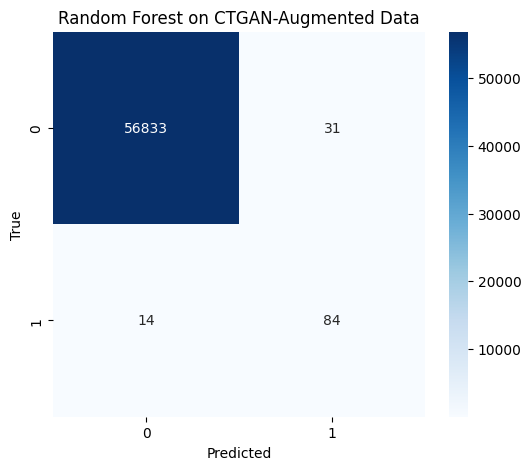

In [ ]:

import numpy as np
import pandas as pd
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# train CTGAN on fraud-only subset
fraud_df = X_train_scaled[y_train == 1].reset_index(drop=True)
ctgan = CTGAN(
    embedding_dim=128,
    generator_dim=(256,256),
    discriminator_dim=(256,256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=500,
    epochs=300,
    pac=10,
    verbose=True
)
ctgan.fit(fraud_df)

#sample synthetic fraud and augment training set
n_synth = 250_000
syn_fraud = ctgan.sample(n_synth)
X_aug = pd.concat([X_train_scaled, syn_fraud], ignore_index=True)
y_aug = np.concatenate([y_train, np.ones(n_synth, dtype=int)])

print(f"Augmented X shape: {X_aug.shape}")
print(f"Augmented y shape: {y_aug.shape}")


rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_aug, y_aug)

# evaluate on hold-out set
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:,1]

roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)
print(f"\nHold-out ROC-AUC: {roc:.4f}")
print(f"Hold-out PR-AUC:  {pr:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest on CTGAN-Augmented Data")
plt.show()


The combination of CTGAN for data augmentation and Random Forest as the classifier delivers outstanding fraud detection performance:

High discriminative power: ROC-AUC ≈ 0.96 and PR-AUC ≈ 0.86–0.87, showing the model balances ranking ability and precision–recall tradeoff well despite class imbalance.

Fraud detection effectiveness: Recall = 0.86 and F1 = 0.79 for the minority (fraud) class, meaning the model successfully captures most fraudulent cases while keeping precision reasonably strong (0.73).

Near-perfect normal detection: For legitimate transactions, precision and recall are ~99.9%, with almost no false alarms (only 31 misclassified out of 56k).

Overall accuracy: ~99.9%, demonstrating the approach does not sacrifice performance on the majority class while still significantly boosting minority class detection.

Reference-https://medium.com/the-research-nest/exploring-gans-to-generate-synthetic-data-ca48f8a4b518

Note- ChatGPT used for understanding results.

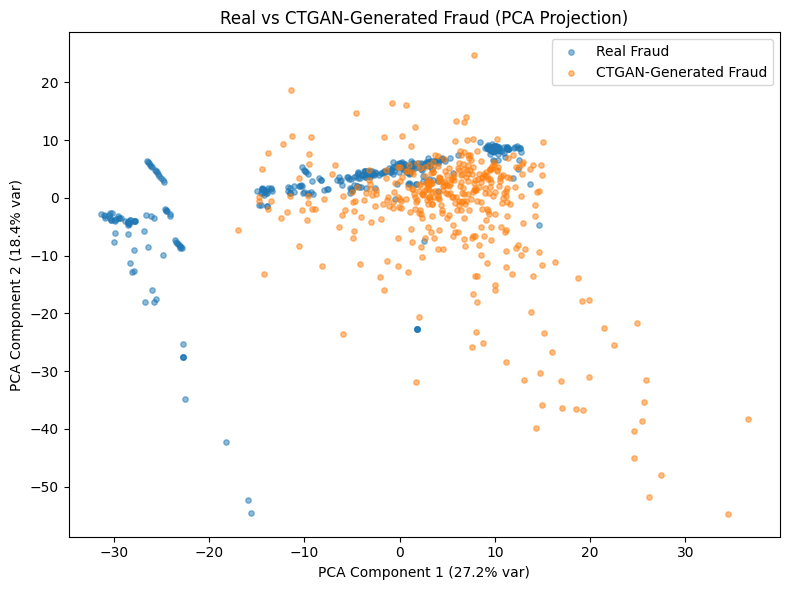

In [ ]:
#PCA: Real Fraud vs CTGAN-Generated Fraud ===
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


real_fraud = X_train_scaled[y_train == 1].reset_index(drop=True)

#  syn_fraud has the same column order as the real data
syn_fraud = syn_fraud[X_train_scaled.columns].reset_index(drop=True)

n_plot = min(len(real_fraud), len(syn_fraud), 20000)  # cap for speed/clarity
rf_idx = np.random.choice(len(real_fraud), n_plot, replace=False)
sf_idx = np.random.choice(len(syn_fraud), n_plot, replace=False)
real_fraud_bal = real_fraud.iloc[rf_idx].to_numpy()
syn_fraud_bal  = syn_fraud.iloc[sf_idx].to_numpy()

# combine and label
combined = np.vstack([real_fraud_bal, syn_fraud_bal])
labels = np.array([0]*n_plot + [1]*n_plot)


pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(combined)
expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
plt.scatter(proj[labels==0, 0], proj[labels==0, 1],
            alpha=0.5, s=15, label='Real Fraud')
plt.scatter(proj[labels==1, 0], proj[labels==1, 1],
            alpha=0.5, s=15, label='CTGAN-Generated Fraud')
plt.xlabel(f"PCA Component 1 ({expl_var[0]*100:.1f}% var)")
plt.ylabel(f"PCA Component 2 ({expl_var[1]*100:.1f}% var)")
plt.title("Real vs CTGAN-Generated Fraud (PCA Projection)")
plt.legend()
plt.tight_layout()
plt.show()


Overlap Region:
The CTGAN-generated fraud points (orange) cluster reasonably close to the real fraud distribution (blue), especially around the denser regions near the PCA component means.
→ This suggests that CTGAN successfully learns the distribution of minority fraud cases and produces synthetic samples that resemble real ones.

Spread/Variance:
The synthetic points exhibit slightly wider variance (especially along PCA Component 2), which can actually be beneficial. It indicates the generator isn’t just memorizing the minority samples but is introducing variation that may help classifiers generalize better.

Outliers:
Both real and synthetic frauds show some outliers, but CTGAN tends to generate more scattered extreme points. These may represent less realistic fraud cases, so filtering or quality evaluation (e.g., via Fréchet Inception Distance for tabular data or TSTR “Train on Synthetic, Test on Real” scores) could help.

This PCA visualization confirms that CTGAN-generated fraud data captures the underlying fraud distribution well, while introducing diversity

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Predicting credit card fraud using conditional generative adversarial network](https://norma.ncirl.ie/6114/), https://www.kaggle.com/datasets/gauravduttakiit/credit-card-fraud-detection-gan

Note- ChatGPT used for understanding results.